1. [Modules](#mods)
2. [Data](#data)
2. [Define the Problem](#define)
3. [Exploratory Analysis](#explore)   
5. [Feature Engineering](#engineer)
6. [Algorithm Selection](#select)
6. [Hyperparameter Selection](#tune)
7. [Model Training](#train)

In [1]:
#basics
import pandas as pd
import numpy as np
#plotting
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split

#### Challenge: Make Your Network

Create a multi-layer perceptron neural network model to predict on a labeled dataset of your choosing. Compare this model to either a boosted tree or a random forest model and describe the relative tradeoffs between complexity and accuracy. Be sure to vary the hyperparameters of your MLP!

#### Data

Context
Crime incident reports are provided by Boston Police Department (BPD) to document the initial details surrounding an incident to which BPD officers respond. This is a dataset containing records from the new crime incident report system, which includes a reduced set of fields focused on capturing the type of incident as well as when and where it occurred.

Content
Records begin in June 14, 2015 and continue to September 3, 2018.

Acknowledgements
The data is provided by Analyze Boston. The most up-to-date version can be found here.

Inspiration
What types of crimes are most common? Where are different types of crimes most likely to occur? Does the frequency of crimes change over the day? Week? Year?

In [3]:
# load and initial cleaning of data
# ansi encoding due to error reading as utf-8
file = 'data/crime.csv'
df = pd.read_csv(file, encoding='ANSI') 
df.columns = [col.lower() for col in df.columns]
# drop rows without location information 
drops = list(np.where(df.lat.isna())[0]) + list(np.where(df.lat == -1)[0])
df = df.drop(drops)
df.index = range(len(df))
#change day_of_week values to numbers 1 thru 7 to allow for ordinal coding
dow = ['Monday', 'Tuesday', 'Wednesday', 'Thursday','Friday','Saturday', 'Sunday']
dct = {k:i + 1 for (i,k) in enumerate(dow)}
df.day_of_week = df.day_of_week.apply(lambda x : dct[x])
# for shooting 1 is True, 0 is False
df.shooting = np.where(df.shooting == 'Y', 1, 0)

In [4]:
C = [col for col in df.columns]
S0 = [len(df[c].unique()) for c in C]
S1 = [len(list(np.where(df[c].isna())[0])) for c in C]
S2 = [str(df[c].dtype) for c in C]
dct = {k:eval('S' + str(i)) for (i,k) in enumerate(['unq_cnt', 'nan_cnt', 'dtype'])}

pd.DataFrame(dct, index=C)

,unq_cnt,nan_cnt,dtype
incident_number,264640,0,object
offense_code,219,0,int64
offense_code_group,67,0,object
offense_description,241,0,object
district,13,897,object
reporting_area,878,0,object
shooting,2,0,int32
occurred_on_date,219625,0,object
year,4,0,int64
month,12,0,int64


In [5]:
df1 = df[['offense_code_group', 'shooting', 'year', 'month', 'hour', 'day_of_week']]
df1.head()

,offense_code_group,shooting,year,month,hour,day_of_week
0,Larceny,0,2018,9,13,7
1,Vandalism,0,2018,8,0,2
2,Towed,0,2018,9,19,1
3,Investigate Property,0,2018,9,21,1
4,Investigate Property,0,2018,9,21,1


In [6]:
# transformer only for "lat" and "long" clustering to create 1 location feature
tfr = Pipeline(steps=[('siz', SimpleImputer(strategy='constant', fill_value=0)),('mms', MinMaxScaler(feature_range=(0, 100)))])
pp1 = ColumnTransformer(transformers=[('cnt', tfr, ['lat','long'])])

In [7]:
df2 = df[['lat','long']]
X2 = pp1.fit_transform(df2)

In [55]:
clu_kmn = KMeans(n_clusters=30, random_state=42)
y_clu = clu_kmn.fit_predict(X2)

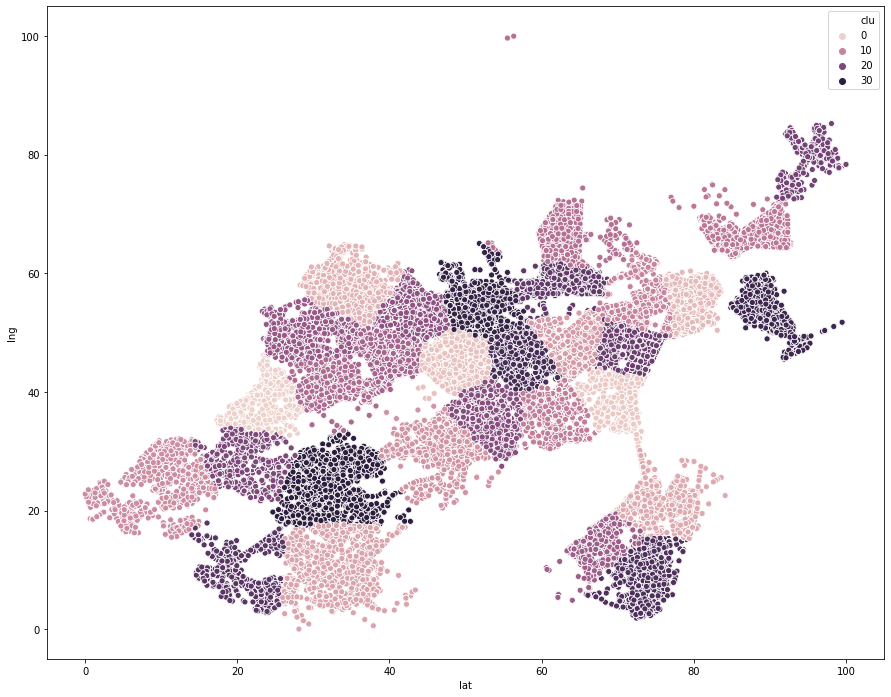

In [56]:
data = pd.concat([pd.DataFrame(X2, columns=['lat', 'lng']), pd.DataFrame(y_clu, columns=['clu'])], axis=1)
f, ax = plt.subplots(1, 1, figsize=(15, 12), sharex=False)
ax = sns.scatterplot(x="lat", y="lng", hue="clu", data=data)
plt.show()

In [57]:
# add the cluster feature
df3 = pd.concat([df1, pd.DataFrame(y_clu, columns=['zone'])], axis=1)
df3.columns = ['offense', 'shoot', 'yr', 'mh', 'hr', 'dow', 'zone']

In [66]:
# increase the number of "shoot" to about 10% of incidents
df4 = df3.loc[df3.shoot == 1]
for i in range(30):
    df3 = pd.concat([df3,df4])
#shuffle the data
idx = list(df3.index); np.random.shuffle(idx)
df3.index = idx; df3.sort_index(axis=0, inplace=True)
df5 = df3.drop(['shoot'],axis=1)

In [67]:
fte_cat = ['offense', 'zone']
fte_ord = ['yr', 'mh', 'hr', 'dow'] 
tfr_ord = Pipeline(steps=[('siz', SimpleImputer(strategy='constant', fill_value=0)),('oer', OrdinalEncoder())])
tfr_cat = Pipeline(steps=[('sin', SimpleImputer(strategy='constant', fill_value='nan')), 
                          ('ohe', OneHotEncoder(categories='auto'))])
pp2 = ColumnTransformer(transformers=[('cat', tfr_cat, fte_cat), ('ord', tfr_ord, fte_ord)])


In [68]:
y = df3.shoot
X = pp2.fit_transform(df5)

In [69]:
df4.shape

(30473, 7)

In [70]:
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.20, random_state=42)

In [71]:
mlp = MLPClassifier()
mlp.fit(X_train, y_train)

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(100,), learning_rate='constant',
              learning_rate_init=0.001, max_iter=200, momentum=0.9,
              n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
              random_state=None, shuffle=True, solver='adam', tol=0.0001,
              validation_fraction=0.1, verbose=False, warm_start=False)

In [72]:
mlp.score(X_test, y_test)

0.997427556943986

In [ ]:
mlp.predict()